# Burgers Optimization with a Physics-Informed NN

To illustrate how the physics-informed losses work for variant 2, let's consider a reconstruction task
as an inverse problem example.
We'll use Burgers equation $\frac{\partial u}{\partial{t}} + u \nabla u = \nu \nabla \cdot \nabla u$ as a simple yet non-linear equation in 1D, for which we have a series of _observations_ at time $t=0.5$. 
The solution should fulfill the residual formulation for Burgers equation and match the observations.
In addition, let's impose Dirichlet boundary conditions $u=0$
at the sides of our computational domain, and define the solution in
the time interval $t \in [0,1]$.

Note that similar to the previous forward simulation example, 
we will still be sampling the solution with 128 points ($n=128$), but now we have a discretization via the NN. So we could also sample points in between without having to explicitly choose a basis function for interpolation. The discretization via the NN now internally determines how to use its degrees of freedom to arrange the activation functions as basis functions. So we have no direct control over the reconstruction.
[[run in colab]](https://colab.research.google.com/github/tum-pbs/pbdl-book/blob/main/physicalloss-code.ipynb)



## Formulation

In terms of the $x,y^*$ notation from {doc}`overview-equations` and the previous section, this reconstruction problem means we are solving

$$
\text{arg min}_{\theta} \sum_i \big( f(x_i ; \theta)-y^*_i \big)^2 + R(x_i) ,
$$

where now $x_i$ denotes a space-time point $x_i=[p_i,t_i]$, the reference solutions are $y^*_i = y^*(x_i)$, and the index $i$ indicates different sampling points for our data set.
Both $f$ and $y^*$ represent the solution of $u$ at different locations in space and time, and
as we're dealing with a 1D velocity, $f, y^*: \mathbb{R}^2 \rightarrow \mathbb{R}$.
In this example, $y^*$ denotes a reference $u$ for $\mathcal{P}$ being Burgers equation, which $f$ should approximate as closely as possible at all chosen space-time points $x_i=[p_i,t_i]$. 

While the first term above is the "supervised" data term, the second one denotes the residual function $R$. It collects additional evaluations of $f(;\theta)$ and its derivatives to formulate the residual for $\mathcal{P}$. This approach -- using derivatives of a neural network to compute a PDE residual -- is typically called a _physics-informed_ approach, yielding a _physics-informed neural network_ (PINN) {cite}`raissi2019pinn` to represent a solution for the inverse reconstruction problem.

Thus, in the formulation above, $R$ should simply converge to zero above. We've omitted scaling factors in the objective function for simplicity. Note that, effectively, we're only dealing with individual point samples of a single solution $u$ for $\mathcal{P}$ here.



## Preliminaries

Let's just load phiflow with the tensorflow backend for now, and initialize the random sampling. (_Note: this example uses an older version 1.5.1 of phiflow._)



In [ ]:
!pip install --quiet phiflow==1.5.1

from phi.tf.flow import *
import numpy as np

#rnd = TF_BACKEND  # for phiflow: sample different points in the domain each iteration
rnd = math.choose_backend(1)  # use same random points for all iterations

We're importing phiflow here, but we won't use it to compute a solution to the PDE as in {doc}`overview-burgers-forw`. Instead, we'll use the  derivatives of an NN (as explained in the previous section) to set up a loss formulation for training.

Next, we set up a simple NN with 8 fully connected layers and `tanh` activations with 20 units each. 

We'll also define the `boundary_tx` function which gives an array of constraints for the solution (all for $t=0.5$ in this example), and the `open_boundary` function which stores constraints for $x= \pm1$ being 0.

In [2]:
def network(x, t):
    """ Dense neural network with 8 hidden layers and 3021 parameters in total.
        Parameters will only be allocated once (auto reuse).
    """
    y = math.stack([x, t], axis=-1)
    for i in range(8):
        y = tf.layers.dense(y, 20, activation=tf.math.tanh, name='layer%d' % i, reuse=tf.AUTO_REUSE)
    return tf.layers.dense(y, 1, activation=None, name='layer_out', reuse=tf.AUTO_REUSE)

def boundary_tx(N):
    x = np.linspace(-1,1,128)
    # precomputed solution from forward simulation:
    u = np.asarray( [0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312] );
    t = np.asarray(rnd.ones_like(x)) * 0.5
    perm = np.random.permutation(128) 
    return (x[perm])[0:N], (t[perm])[0:N], (u[perm])[0:N]

def _ALT_t0(N): # alternative, impose original initial state at t=0
    x = rnd.random_uniform([N], -1, 1)
    t = rnd.zeros_like(x)
    u = - math.sin(np.pi * x)
    return x, t, u

def open_boundary(N):
    t = rnd.random_uniform([N], 0, 1)
    x = math.concat([math.zeros([N//2]) + 1, math.zeros([N//2]) - 1], axis=0)
    u = math.zeros([N])
    return x, t, u


Most importantly, we can now also construct the residual loss function `f` that we'd like to minimize in order to guide the NN to retrieve a solution for our model equation. As can be seen in the equation at the top, we need derivatives w.r.t. $t$, $x$ and a second derivative for $x$. The first three lines of `f` below do just that.

Afterwards, we simply combine the derivates to form Burgers equation. Here we make use of phiflow's `gradient` function:

In [3]:
def f(u, x, t):
    """ Physics-based loss function with Burgers equation """
    u_t = gradients(u, t)
    u_x = gradients(u, x)
    u_xx = gradients(u_x, x)
    return u_t + u*u_x - (0.01 / np.pi) * u_xx


Next, let's set up the sampling points in the inner domain, such that we can compare the solution with the previous forward simulation in phiflow. 

The next cell allocates two tensors: `grid_x` will cover the size of our domain, i.e., the -1 to 1 range, with 128 cells, while `grid_t` will sample the time interval $[0,1]$ with 33 time stamps.

The last `math.expand_dims()` call simply adds another `batch` dimension, so that the resulting tensor is compatible with the following examples.



In [ ]:
N=128
grids_xt = np.meshgrid(np.linspace(-1, 1, N), np.linspace(0, 1, 33), indexing='ij')
grid_x, grid_t = [tf.convert_to_tensor(t, tf.float32) for t in grids_xt]

# create 4D tensor with batch and channel dimensions in addition to space and time
# in this case gives shape=(1, N, 33, 1)
grid_u = math.expand_dims(network(grid_x, grid_t))

Now, `grid_u` contains a full graph to evaluate our NN at $128 \times 33$ positions, and returns the results in a $[1,128,33,1]$ array once we run it through `session.run`. Let's give this a try: we can initialize a TF session, evaluate `grid_u` and show it in an image, just like the phiflow solution we computed previously. 

(Note, we'll use the `show_state` as in {doc}`overview-burgers-forw`. Hence, the x axis does not show actual simulation time, but is showing 32 steps "blown" up by a factor of 16 to make the changes over time easier to see in the image.)

Size of grid_u: (1, 128, 33, 1)
Randomly initialized network state:


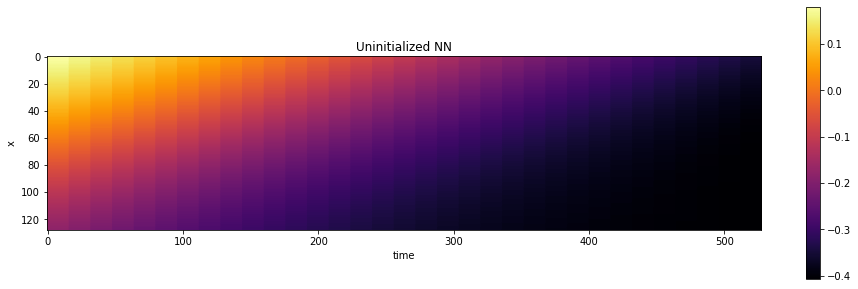

In [5]:
import pylab as plt
print("Size of grid_u: "+format(grid_u.shape))

session = Session(None)
session.initialize_variables()

def show_state(a, title):
    for i in range(4): a = np.concatenate( [a,a] , axis=3)
    a = np.reshape( a, [a.shape[1],a.shape[2]*a.shape[3]] )
    fig, axes = plt.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    plt.colorbar(im) ; plt.xlabel('time'); plt.ylabel('x'); plt.title(title)
    
print("Randomly initialized network state:")
show_state(session.run(grid_u),"Uninitialized NN")

This visualization already shows a smooth transition over space and time. So far, this is purely the random initialization of the NN that we're sampling here. So it has nothing to do with a solution of our PDE-based model up to now.

The next steps will actually evaluate the constraints in terms of data (from the `boundary` functions), and the model constraints from `f` to retrieve an actual solution to the PDE.

## Loss function and training

As objective for the learning process we can now combine the _direct_ constraints, i.e., the solution at $t=0.5$ and the Dirichlet $u=0$ boundary conditions with the loss from the PDE residuals. For both boundary constraints we'll use 100 points below, and then sample the solution in the inner region with an additional 1000 points.

The direct constraints are evaluated via `network(x, t)[:, 0] - u`, where `x` and `t` are the space-time location where we'd like to sample the solution, and `u` provides the corresponding ground truth value.

For the physical loss points, we have no ground truth solutions, but we'll only evaluate the PDE residual via the NN derivatives, to see whether the solution satisfies the PDE model. If not, this directly gives us an error to be reduced via an update step in the optimization. The corresponding expression is of the form  `f(network(x, t)[:, 0], x, t)` below. Note that for both data and physics terms the `network()[:, 0]` expressions don't remove any data from the $L^2$ evaluation, they simply discard the last size-1 dimension of the $(n,1)$ tensor returned by the network.

In [ ]:
# Boundary loss
N_SAMPLE_POINTS_BND = 100
x_bc, t_bc, u_bc = [math.concat([v_t0, v_x], axis=0) for v_t0, v_x in zip(boundary_tx(N_SAMPLE_POINTS_BND), open_boundary(N_SAMPLE_POINTS_BND))]
x_bc, t_bc, u_bc = np.asarray(x_bc,dtype=np.float32), np.asarray(t_bc,dtype=np.float32) ,np.asarray(u_bc,dtype=np.float32)
#with app.model_scope():
loss_u = math.l2_loss(network(x_bc, t_bc)[:, 0] - u_bc)  # normalizes by first dimension, N_bc

# Physics loss inside of domain
N_SAMPLE_POINTS_INNER = 1000
x_ph, t_ph = tf.convert_to_tensor(rnd.random_uniform([N_SAMPLE_POINTS_INNER], -1, 1)), tf.convert_to_tensor(rnd.random_uniform([N_SAMPLE_POINTS_INNER], 0, 1))
loss_ph = math.l2_loss(f(network(x_ph, t_ph)[:, 0], x_ph, t_ph))  # normalizes by first dimension, N_ph

# Combine
ph_factor = 1.
loss = loss_u + ph_factor * loss_ph # allows us to control the relative influence of loss_ph 

optim = tf.train.GradientDescentOptimizer(learning_rate=0.02).minimize(loss)
#optim = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss) # alternative, but not much benefit here


The code above just initializes the evaluation of the loss, we still didn't do any optimization steps, but we're finally in a good position to get started with this.

Despite the simple equation, the convergence is typically very slow. The iterations themselves are fast to compute, but this setup needs a _lot_ of iterations. To keep the runtime in a reasonable range, we only do 10k iterations by default below (`ITERS`). You can increase this value to get better results.

In [7]:
session.initialize_variables()

import time
start = time.time()

ITERS = 10000
for optim_step in range(ITERS+1):
  _, loss_value = session.run([optim, loss])
  if optim_step<3 or optim_step%1000==0: 
        print('Step %d, loss: %f' % (optim_step,loss_value))
        #show_state(grid_u)
        
end = time.time()
print("Runtime {:.2f}s".format(end-start))

Step 0, loss: 0.100037
Step 1, loss: 0.097836
Step 2, loss: 0.096151
Step 1000, loss: 0.054487
Step 2000, loss: 0.049147
Step 3000, loss: 0.045515
Step 4000, loss: 0.042890
Step 5000, loss: 0.039945
Step 6000, loss: 0.037641
Step 7000, loss: 0.035227
Step 8000, loss: 0.033604
Step 9000, loss: 0.031556
Step 10000, loss: 0.029434
Runtime 110.02s


The training can take a significant amount of time, around 2 minutes on a typical notebook, but at least the error goes down significantly (roughly from around 0.2 to ca. 0.03), and the network seems to successfully converge to a solution.

Let's show the reconstruction of the network, by evaluating the network at the centers of a regular grid, so that we can show the solution as an image. Note that this is actually fairly expensive, we have to run through the whole network with a few thousand weights for all of the $128 \times 32$ sampling points in the grid.

It looks pretty good on first sight, though. There's been a very noticeable change compared to the random initialization shown above:


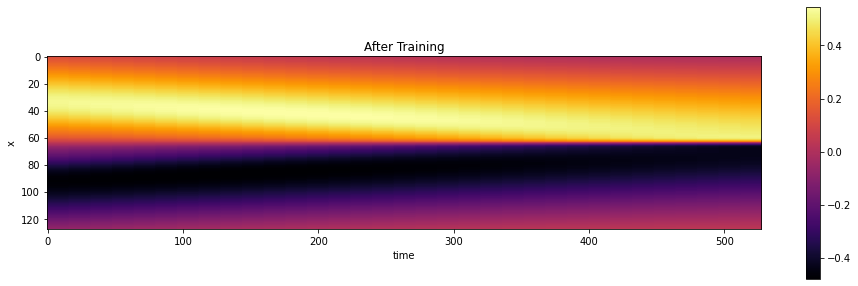

In [8]:
show_state(session.run(grid_u),"After Training") 

---

## Evaluation

Let's compare solution in a bit more detail. Here are the actual sample points used for constraining the solution (at time step 16, $t=1/2$) shown in gray, versus the reconstructed solution in blue:


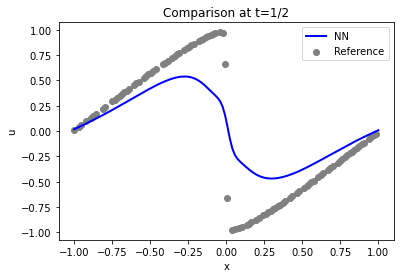

In [9]:
u = session.run(grid_u)

# solution is imposed at t=1/2 , which is 16 in the array
BC_TX = 16 
uT = u[0,:,BC_TX,0]

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(uT)), uT, lw=2, color='blue', label="NN")
fig.scatter(x_bc[0:100], u_bc[0:100], color='gray', label="Reference")
plt.title("Comparison at t=1/2")
plt.xlabel('x'); plt.ylabel('u'); plt.legend()


Not too bad at the sides of the domain (the Dirichlet boundary conditions $u=0$ are fulfilled), but the shock in the center (at $x=0$) is not well represented.

Let's check how well the initial state at $t=0$ was reconstructed. That's the most interesting, and toughest part of the problem (the rest basically follows from the model equation and boundary conditions, given the first state).

It turns out that the accuracy of the initial state is actually not that good: the blue curve from the PINN is quite far away from the constraints via the reference data (shown in gray)... The solution will get better with larger number of iterations, but it requires a surprisingly large number of iterations for this fairly simple case. 


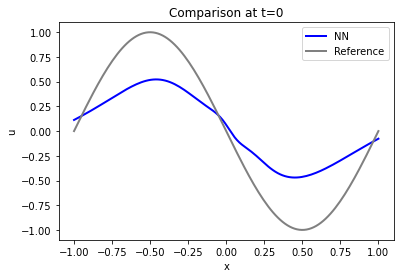

In [10]:
# ground truth solution at t0
t0gt = np.asarray( [ [-math.sin(np.pi * x) * 1.] for x in np.linspace(-1,1,N)] )
velP0 = u[0,:,0,0]

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(velP0)), velP0, lw=2, color='blue', label="NN")
fig.plot(np.linspace(-1,1,len(t0gt)), t0gt, lw=2, color='gray', label="Reference") 
plt.title("Comparison at t=0")
plt.xlabel('x'); plt.ylabel('u'); plt.legend()


Especially the maximum / minimum at $x=\pm 1/2$ are far off, and the boundaries at $x=\pm 1$ are not fulfilled: the solution is not at zero.

We have the forward simulator for this simulation, so we can use the $t=0$ solution of the network to 
evaluate how well the temporal evaluation was reconstructed. This measures how well the temporal evolution of the model equation was captured via the soft constraints of the PINN loss.

The graph below shows the initial state in blue, and two evolved states at $t=8/32$ and $t=15/32$. Note that this is all from the simulated version, we'll show the learned version next. 

(Note: The code segments below also have some optional code to show the states at `[STEPS//4]`. It's commented out by default, you can uncomment or add additional ones to visualize more of the time evolution if you like.)

(1, 128, 1)


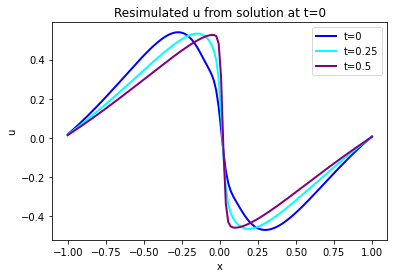

In [11]:
# re-simulate with phiflow from solution at t=0
DT = 1./32.
STEPS = 32-BC_TX # depends on where BCs were imposed
INITIAL = u[...,BC_TX:(BC_TX+1),0] # np.reshape(u0, [1,len(u0),1]) 
print(INITIAL.shape)

DOMAIN = Domain([N], boundaries=PERIODIC, box=box[-1:1])
state = [BurgersVelocity(DOMAIN, velocity=INITIAL, viscosity=0.01/np.pi)]
physics = Burgers()

for i in range(STEPS):
    state.append( physics.step(state[-1],dt=DT) )

# we only need "velocity.data" from each phiflow state
vel_resim = [x.velocity.data for x in state]

fig = plt.figure().gca()
pltx = np.linspace(-1,1,len(vel_resim[0].flatten()))
fig.plot(pltx, vel_resim[ 0].flatten(),       lw=2, color='blue',  label="t=0")
#fig.plot(pltx, vel_resim[STEPS//4].flatten(), lw=2, color='green', label="t=0.125")
fig.plot(pltx, vel_resim[STEPS//2].flatten(), lw=2, color='cyan',  label="t=0.25")
fig.plot(pltx, vel_resim[STEPS-1].flatten(),  lw=2, color='purple',label="t=0.5")
#fig.plot(pltx, t0gt, lw=2, color='gray', label="t=0 Reference") # optionally show GT, compare to blue
plt.title("Resimulated u from solution at t=0")
plt.xlabel('x'); plt.ylabel('u'); plt.legend()

And here is the PINN output from `u` at the same time steps:


(128,)


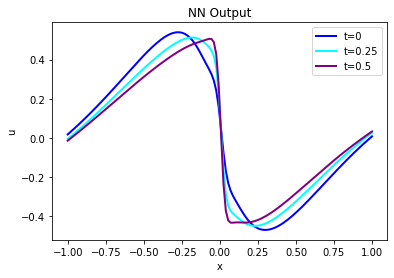

In [12]:
velP = [u[0,:,x,0] for x in range(33)]
print(velP[0].shape)

fig = plt.figure().gca()
fig.plot(pltx, velP[BC_TX+ 0].flatten(),       lw=2, color='blue',  label="t=0")
#fig.plot(pltx, velP[BC_TX+STEPS//4].flatten(), lw=2, color='green', label="t=0.125")
fig.plot(pltx, velP[BC_TX+STEPS//2].flatten(), lw=2, color='cyan',  label="t=0.25")
fig.plot(pltx, velP[BC_TX+STEPS-1].flatten(),  lw=2, color='purple',label="t=0.5")
plt.title("NN Output")
plt.xlabel('x'); plt.ylabel('u'); plt.legend()

Judging via eyeball norm, these two versions of $u$ look quite similar, but not surprisingly the errors grow over time and there are significant differences. Especially the steepening of the solution near the shock at $x=0$ is not "captured" well. It's a bit difficult to see in these two graphs, though, let's quantify the error and show the actual difference:

Mean absolute error for re-simulation across 16 steps: 0.01136


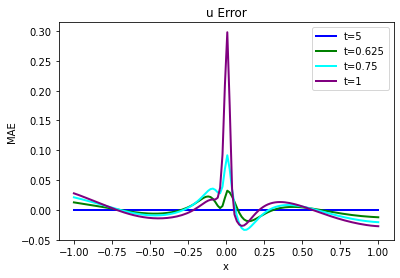

In [13]:
error = np.sum( np.abs( np.asarray(vel_resim[0:16]).flatten() - np.asarray(velP[BC_TX:BC_TX+STEPS]).flatten() )) / (STEPS*N)
print("Mean absolute error for re-simulation across {} steps: {:7.5f}".format(STEPS,error))

fig = plt.figure().gca()
fig.plot(pltx, (vel_resim[0       ].flatten()-velP[BC_TX         ].flatten()), lw=2, color='blue',  label="t=5")
fig.plot(pltx, (vel_resim[STEPS//4].flatten()-velP[BC_TX+STEPS//4].flatten()), lw=2, color='green', label="t=0.625")
fig.plot(pltx, (vel_resim[STEPS//2].flatten()-velP[BC_TX+STEPS//2].flatten()), lw=2, color='cyan',  label="t=0.75")
fig.plot(pltx, (vel_resim[STEPS-1 ].flatten()-velP[BC_TX+STEPS-1 ].flatten()), lw=2, color='purple',label="t=1")
plt.title("u Error")
plt.xlabel('x'); plt.ylabel('MAE'); plt.legend()


The code above will compute a mean absolute error of ca. $1.5 \cdot 10^{-2}$ between ground truth re-simulation and the PINN evolution, which is significant for the value range of the simulation.

And for comparison with the forward simulation and following cases, here are also all steps over time with a color map.

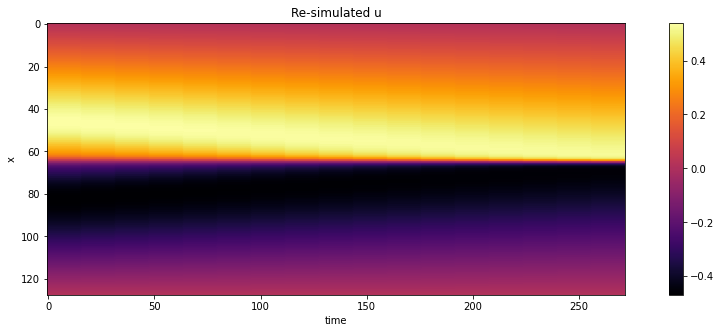

In [14]:
# show re-simulated solution again as full image over time
sn = np.concatenate(vel_resim, axis=-1)
sn = np.reshape(sn, list(sn.shape)+[1] ) # print(sn.shape)
show_state(sn,"Re-simulated u")

Next, we'll store the full solution over the course of the $t=0 \dots 1$ time interval, so that we can compare it later on to the full solution from a regular forward solve and compare it to the differential physics solution.

Thus, stay tuned for the full evaluation and the comparison. This will follow in {doc}`diffphys-code-burgers`, after we've discussed the details of how to run the differential physics optimization.

In [15]:
vels = session.run(grid_u) # special for showing NN results, run through TF 
vels = np.reshape( vels, [vels.shape[1],vels.shape[2]] )

# save for comparison with other methods
import os; os.makedirs("./temp",exist_ok=True)
np.savez_compressed("./temp/burgers-pinn-solution.npz",vels) ; print("Vels array shape: "+format(vels.shape))

Vels array shape: (128, 33)


---

## Next steps

This setup is just a starting point for PINNs and physical soft-constraints, of course. The parameters of the setup were chosen to run relatively quickly. As we'll show in the next sections, the behavior of such an inverse solve can be improved substantially by a tighter integration of solver and learning. 

The solution of the PINN setup above can also directly be improved, however. E.g., try to:

* Adjust parameters of the training to further decrease the error without making the solution diverge.
* Adapt the NN architecture for further improvements (keep track of the weight count, though).
* Activate a different optimizer, and observe the change in behavior (this typically requires adjusting the learning rate). Note that the more complex optimizers don't necessarily do better in this relatively simple example.
* Or modify the setup to make the test case more interesting: e.g., move the boundary conditions to a later point in simulation time, to give the reconstruction a larger time interval to reconstruct.